# 기본 함수 및 라이르러리 로드

###### 라이브러리 로드

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
%matplotlib inline

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

## 필요 함수 로드

In [2]:
def get_object_type(df):
    df['상권_코드'] = df['상권_코드'].apply(lambda x : str(x))
    df.astype({'상권_코드':object})
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1)) 

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
# 피밸류 보는 함수
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
def get_summary(X,y):
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_VIF(df):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

## 검정 함수

### vif 관련 함수

In [6]:
least = 55

In [7]:
def get_vif(X, least=100, show=True):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # 피처마다의 VIF 계수를 출력(소수점 4째자리까지만 출력)
    pd.options.display.float_format = '{:.4f}'.format

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    if show:
        print(vif)
        print('\n')
    vif = vif[vif['features']!='const']
    return vif[vif['VIF Factor']>least]

In [8]:
def get_vif_highest_feature(X, least):
    highest_df = get_vif(X, least, show=False)
    if highest_df.shape[0]>1:
        highest_feature = highest_df.sort_values('VIF Factor', ascending=False).tail(1)['features'].iloc[0]
        return highest_feature
    else:
        return False

In [9]:
def get_clear_df_by_vif(X, least):
    higher_than_least_features = []
    selected_feature = False
    left_feature = X.columns.to_list()
    while True:
        if selected_feature:
            left_feature.remove(selected_feature)  
        selected_feature = get_vif_highest_feature(X.loc[:,left_feature], least)
        if selected_feature:
#             print(selected_feature)
            higher_than_least_features.append(selected_feature)
        else:
            break
    return higher_than_least_features

In [10]:
def get_corr(df):

    plt.rcParams['font.family'] = 'Malgun Gothic'
    # cmap = sns.light_palette("darkgray", as_cmap=True)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df.corr(), annot=True, cmap=cmap)
    plt.show()

### AIC 기반 회귀 함수

In [11]:
def processSubset(X,y,feature_set):

    feature = list(feature_set) 
    model = sm.OLS(y,X[feature]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    data = regr.summary()
    return {"model" : regr, "AIC" : AIC, "SUMMARY":data, "Features":feature}
    

In [12]:
import time
import itertools 

# getBest : 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수

def getBest(X,y,k):
    tic = time.time()      # 시작 시간
    results = []           # 결과 저장 공간
    for combo in itertools.combinations(X.columns.difference(['const']),k):
        # 각 변수 조합을 고려한 경우의수
        
        combo = (list(combo)+['const'])
        # 상수항을 추가하여 combo를 결성
        
        results.append(processSubset(X,y,feature_set = combo)) # 모델링된것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분석하여
        # 저장 후 그 중 AIC가 가장 낮은 모델을 선택하도록 함

    models = pd.DataFrame(results) # 데이터프레임으로 모델결과 변환
    best_model = models.loc[models['AIC'].argmin()] # argmin은 최소값의 인덱스를 뽑는 함수
    toc = time.time()       # 종료 시간
    print("Processed", models.shape[0], "models on", k, "predictors in",(toc - tic),"seconds.")
    
    return best_model

###### 전진선택법

In [13]:
### 전진석택법(step=1)

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    return Fmodels
#     return (Fmodels['model'][len(Fmodels['model'])])


###### 후진소거법

In [14]:
### 후진소거법(step=1)

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model","SUMMARY","Features"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[idx] = Backward_result
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
        idx+=1
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels.dropna()
#     return Bmodels["model"].dropna().iloc[0]

#### 단계적 선택법

In [15]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model","SUMMARY",'Features'])
    tic = time.time()
    predictors = []
    Stepmodels.loc[1] = getBest(X,y,k=1)
#     Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    predictors = Stepmodels.loc[1]['model'].model.exog_names
    predictors = [k for k in predictors if k != "const"]
    print(predictors)
    Smodel_before = Stepmodels.loc[1]['AIC']
    
    # 변수 1~10개 0-9 -> 1-10
    for i in range(2,len(X.columns.difference(['const']))+1) :
        print('step:',i-1)

        Forward_result = forward(X=X,y=y,predictors = predictors ) # constant added
        Backward_result = backward(X=X,y=y,predictors = predictors)
        
        
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('backward')
            
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            predictors = [k for k in predictors if k != "const"]
            print('##forward##')
            
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
            
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Stepmodels
#     return (Stepmodels["model"][len(Stepmodels["model"])])

###### AIC 시각화

In [16]:
def vis_AIC_step(result):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')
 
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC  = result['AIC'].to_list()
    features = [f'step {i+1}\n'+'\n'.join(s) for i,s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps,AIC, marker='o')
    
    plt.ylabel('AIC',fontsize=font_size)
    plt.grid(True)
    plt.show()
 

### R-square 기반

#### 전진선택법

In [17]:
def forward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])

    ## 전진 선택법
    variables = df_X.columns.tolist() ## 설명 변수 리스트

    # df_y= df['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())

            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit().rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
        
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result


#### 후진선택법

In [18]:
def backward_R_sq(df_X, df_y):
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 후진 소거법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = variables ## 초기에는 모든 변수가 선택된 상태
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(selected_variables) > 0:
        X = sm.add_constant(df_X[selected_variables])
        p_vals = sm.OLS(df_y,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
        max_pval = p_vals.max() ## 최대 p-value
        if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
            remove_variable = p_vals.idxmax()
            selected_variables.remove(remove_variable)

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()
    
    return df_result




#### 단계적 선택법

In [19]:
def stepwise_R_sq(df_X, df_y):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    df_result = pd.DataFrame(columns=["R_square","model","SUMMARY","Features"])
    ## 전진 단계별 선택법
    variables = df_X.columns[:-2].tolist() ## 설명 변수 리스트

    # df_y= df_X['Survival_Time'] ## 반응 변수
    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05

    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = df_X[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.OLS(df_y,X).fit()
            pval[col] = model.pvalues[col]

        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = df_X[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(df_y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break

            step += 1
            steps.append(step)
            model = sm.OLS(df_y,sm.add_constant(df_X[selected_variables])).fit()
            adj_r_squared = model.rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
            df_result.loc[step] = adj_r_squared, model, model.summary(), selected_variables.copy()
        else:
            break
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')

    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_r_squared, marker='o')

    plt.ylabel('Adjusted R Squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return df_result

### 최적화 함수

In [20]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_summary_by_R(model):
    return model.sort_values('R_square', ascending=False).head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_best_feature_by_R(model):
    return model.sort_values('R_square', ascending=False).head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

def get_adj_r_squared_by_R_model(model):
    summary = get_best_summary_by_R(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

###### 자료 로드

###### base 생성

In [21]:
bs_area = gpd.read_file('data/geojson/상권_geometry_좌표.geojson', driver= 'GeoJSON')
bs_area= bs_area[bs_area['TRDAR_SE_C'] == 'A']
df_base = bs_area[['TRDAR_CD','TRDAR_SE_1']].sort_values('TRDAR_CD').reset_index(drop=True)
df_base.columns = ['상권_코드', '상권_이름']
df_base = get_object_type(df_base)
df_base.head()

,상권_코드
0,1000001
1,1000002
2,1000003
3,1000004
4,1000005


#   4대지표 정리

## 1. 상권이 얼마나 발달했는가?

* 단순지표

1. 총매출

2. 고객수를 대표 할 지수

3. 점포의 수

5. 유동인구

5. 가게 생존률 : 개폐업률

6. 면적

*  복합지표



1. 면적대비 매출

2. 점포수 대비 매출

3. 면적 대비 점포수

1. 재방문율? 고정 방문 고객수? 

In [22]:
df_i1_development = pd.read_csv('data/indicator/상권_발달_지수.csv')
df_i1_development = get_object_type(df_i1_development)
df_i1_development

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,개폐업_비율
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217,1.250000
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826,0.444444
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380,0.542857
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080,0.666667
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101,1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,1.250092e+10,23.249068,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076,0.600000
1006,1001007,1.723727e+10,23.570340,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539,1.100000
1007,1001008,2.267043e+10,23.844327,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507,0.777778
1008,1001009,8.707442e+09,22.887444,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402,0.777778


##  2. 상권의 고객층은 어떠한가?

* 단순지표

1. 업종별 매출 금액 : 
2. 요일별 매출 금액 : 구성(비율) -  실 거래가도 필요!!
3. 소득 수준 : 변형 방식 잘못됨 - 원래 값 가지고 오면,  정규화 하느게 나을거 같음!
4. 성별?! : 매출에 대한 비율, 실 거래가 필요!!
5. 연령?! : 매출에 대한 비율, 실 거래가 필요 !!


* 복합지표

1. 상권의 다양성 : ok!
2. 고객의 유입성 - 매출을 고객수로 나누어야 하는거 아닌가? 
3. 라이프 지수?!

* 부탁 : 총직장 인구수 --> 상권 발달 지수로 편입

In [23]:
df_i2_diversity = pd.read_csv('data/indicator/상권_다양성_지수.csv')
df_i2_diversity = get_object_type(df_i2_diversity)
df_i2_diversity

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,2.383339e+07,3.140614e+08,1.844958e+08,3.401026e+09,1.098479e+08,2.162874e+07,1.104666e+09,7.539225e+08,0.004030,0.053109,0.031199,0.575131,0.018576,0.003658,0.186805,0.127492,1.793861e+09,1.989043e+09,2.249773e+09,2.002910e+09,2.336899e+09,2.775185e+09,1.978902e+09,5.268174e+09,8.349831e+09,0.062407,0.069197,0.078268,0.069680,0.081299,0.096546,0.068844,0.386854,0.613146,56459184,3.431027,3497.822761,2.760323e+05,54800
1,1000002,3.323505e+07,1.233347e+09,0.000000e+00,2.824262e+08,0.000000e+00,1.649548e+07,2.757601e+08,5.625196e+08,0.013826,0.513086,0.000000,0.117492,0.000000,0.006862,0.114719,0.234014,1.864865e+09,1.861095e+09,2.020037e+09,2.010279e+09,2.507377e+09,3.009626e+09,2.721385e+09,6.232730e+09,9.299999e+09,0.059151,0.059031,0.064072,0.063763,0.079530,0.095461,0.086318,0.401264,0.598736,52528944,3.090867,1097.584441,3.396471e+05,47092
2,1000003,2.687648e+08,6.158692e+08,5.146111e+09,2.088953e+09,3.048000e+06,9.421422e+07,4.283574e+08,7.717781e+08,0.028540,0.065399,0.546465,0.221826,0.000324,0.010005,0.045487,0.081955,4.151880e+09,4.147718e+09,4.099405e+09,3.529069e+09,4.115786e+09,6.076924e+09,2.622511e+09,1.490993e+10,1.083067e+10,0.076204,0.076127,0.075241,0.064773,0.075541,0.111536,0.048134,0.579238,0.420762,46548880,3.492629,4147.017560,1.818920e+05,158024
3,1000004,2.845950e+06,2.521403e+07,5.960735e+07,1.048493e+09,1.619301e+08,1.963030e+07,2.291818e+08,9.595252e+08,0.001135,0.010060,0.023782,0.418322,0.064606,0.007832,0.091438,0.382826,1.677315e+09,1.723738e+09,1.796036e+09,1.495531e+09,1.689890e+09,1.324265e+09,1.015283e+09,5.602198e+09,4.587237e+09,0.080210,0.082430,0.085888,0.071517,0.080812,0.063327,0.048551,0.549805,0.450195,47223072,2.480483,846.936653,1.580492e+06,6784
4,1000005,0.000000e+00,1.305581e+08,8.196169e+07,4.654974e+09,0.000000e+00,1.527319e+09,5.503179e+08,4.557695e+08,0.000000,0.017641,0.011075,0.628974,0.000000,0.206369,0.074358,0.061583,8.446228e+08,1.235422e+09,1.465347e+09,1.186086e+09,1.481575e+09,2.264371e+09,1.957322e+09,4.489870e+09,4.827498e+09,0.042761,0.062546,0.074187,0.060049,0.075008,0.114639,0.099094,0.481882,0.518118,63642816,3.274153,5668.408506,6.135199e+05,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,2.512648e+07,1.447867e+08,2.804269e+08,1.181328e+09,2.466564e+07,2.065871e+08,9.684341e+08,1.122737e+09,0.006355,0.036617,0.070921,0.298761,0.006238,0.052246,0.244919,0.283943,1.766752e+09,1.910530e+09,1.910759e+09,2.026241e+09,1.659804e+09,1.935173e+09,1.291661e+09,6.268783e+09,5.806702e+09,0.071888,0.077738,0.077748,0.082447,0.067536,0.078741,0.052557,0.519133,0.480867,48022416,3.577553,541.685637,1.472776e+06,8488
1006,1001007,3.343640e+06,1.694507e+08,7.354804e+07,1.514327e+09,1.984390e+08,5.059799e+09,1.252837e+09,6.572703e+09,0.000225,0.011415,0.004955,0.102013,0.013368,0.340855,0.084398,0.442772,2.363785e+09,2.517307e+09,3.468178e+09,2.780483e+09,2.931596e+09,2.226779e+09,9.491458e+08,1.078403e+10,5.365248e+09,0.070801,0.075399,0.103879,0.083282,0.087808,0.066697,0.028429,0.667772,0.332228,40991088,3.407494,3053.619034,4.460992e+06,3864
1007,1001008,3.649771e+07,3.771270e+08,2.032622e+07,3.218844e+09,0.000000e+00,3.447343e+07,2.286670e+08,3.225350e+08,0.008611,0.088977,0.004796,0.759435,0.000000,0.008133,0.053950,0.076097,2.678396e+09,3.042313e+09,3.040061e+09,3.019629e+09,3.781381e+09,4.055309e+09,3.053337e+09,1.371922e+10,8.391559e+09,0.059811,0.067937,0.067887,0.067431,0.084441,0.090558,0.068183,0.620477,0.379523,44387424,3.228552,780.36

In [24]:
df_i2_diversity.columns = [x.replace('다양성_지수', '고객_다양성_지수') for x in df_i2_diversity.columns]

## 3. 상권의 지리적 특성은 어떠한가?

In [25]:
df_i3_geo = pd.read_csv('data/indicator/상권_지리적_지표.csv')
df_i3_geo = get_object_type(df_i3_geo)
df_i3_geo

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,다양성_지수
0,1000001,4.675446e+06,544.0,2800.0,582.0,245.0,3.917831e-09,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.777462
1,1000002,3.689914e+06,179.0,4372.0,5775.0,2984.0,4.348221e-09,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.796312
2,1000003,1.241185e+07,32.0,982.0,1386.0,0.0,5.626303e-09,29.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,4.0,2.0,0.0,1.082380
3,1000004,4.357117e+06,917.0,4753.0,2021.0,124.0,6.733993e-09,8.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.970116
4,1000005,1.612400e+06,421.0,1210.0,2220.0,1006.0,2.961807e-09,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4.224173e+06,853.0,6621.0,15482.0,3488.0,4.517399e-09,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.636514
1006,1001007,2.451149e+06,377.0,2274.0,1092.0,0.0,6.468466e-09,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.960892
1007,1001008,4.373616e+06,590.0,3890.0,4402.0,44.0,5.391740e-09,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.636514
1008,1001009,4.373616e+06,765.0,4435.0,8920.0,2724.0,4.930576e-09,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.848686


In [26]:
df_i3_geo.columns = [x.replace('다양성_지수', '지리_다양성_지수') for x in df_i3_geo.columns]

##  4. 문화적 코드는 어떠한가?

* 단순지표

1. 상권별 단순 좋아요 표현

* 범위를 어떻게 나눌까?  빈도수 각상권만의 빈도수로 하기에는 1010 너무 많아 무의미 하고


* 문화적 코드를 제외하고서  클러스터링 할꺼자나: 클러스터링 한 레이블 값: 상권 상호 보안적으로 나가는거지

* 15나눴더니... 문화적 5개로 나눠진다...

 나눈 다른 코드에서 나누어진 클러스터링 값에 따른 빈도수 / 서울 전체 빈도수 
 
 
 
///////////////////////


이제부터 분석인데!!




// 클러스터링 // 

일단 , 리뷰 식당 이니까... 대표성 

상권 쳐먹!!... 안타 까운

-------------------------

의류 / 패션 


숫자...

어떤 의미를 가지는 숫자를
구하는냐?



리뷰 데이터를 어떻게 정형화 해서 각 상권_코드 숫자를 줄것인가?

    레이블 주거나!!
    
    

클러스터링/// 1010 // 주요 클러스터를 10 ~ 20 개 유사도를 판별하는 

결론 : 솔루션

부족한지를 찾아주는게 좋은데

일치도를 사용 해서

클러스터링 

-------------------------

잘 나가는 대표 을 보고 . 

그 수치값  점포당 유동인구수 나 활동인구수 == 

다양성 이 떨어진다거나... 리뷰 숫자가 적거나 문화정 지수 xxxxxxxxxx  

같은 조건 임에도 불구하고 찾을 수가 없다. 


---> 거리를 지정해서, 문화 공연

위드 코로나 행사 마련 

추천 시스템

df_i4_culture = 

1. 다중공성선 평가 : VIF

2. Feature Selection : Stepwise, 



1. 단순 지표로 



2. 경향성을 보는 거면 될꺼 같애 회귀 계수 




# 회귀를 통한 영향력 평가

## 4대지표 1차 가공

### 종속변수 설정

In [27]:
# # 20_3_4~21_1_2 분기 회귀 계수
# df_t_total = pd.read_csv('data/j_result/수정_매출_회귀계수.csv')
# df_t_total = get_object_type(df_t_total)

df_t_total

20_3_4~21_1_2 분기 회귀 계수는 우선 사용 하지 말고,

In [28]:
df_1년매출 = df_i1_development.iloc[:,:2]

In [29]:
# 1년 매출
df_1년매출

,상권_코드,1년_매출
0,1000001,1.512657e+10
1,1000002,1.599466e+10
2,1000003,2.874329e+10
3,1000004,1.072206e+10
4,1000005,1.043475e+10
...,...,...
1005,1001006,1.250092e+10
1006,1001007,1.723727e+10
1007,1001008,2.267043e+10
1008,1001009,8.707442e+09


### 발달지수

In [30]:
df_i1_development.head()

,상권_코드,1년_매출,1년_매출_log,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,개폐업_비율
0,1000001,1.512657e+10,23.439719,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.0,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217,1.250000
1,1000002,1.599466e+10,23.495521,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.0,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826,0.444444
2,1000003,2.874329e+10,24.081670,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.0,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380,0.542857
3,1000004,1.072206e+10,23.095569,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.5,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080,0.666667
4,1000005,1.043475e+10,23.068407,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.5,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101,1.800000


In [31]:
df_i1_development = df_i1_development.drop(['1년_매출', '1년_매출_log'], axis=1)
df_i1_development

,상권_코드,배후지_총_생활인구_수,배후지_남성_생활인구_수,배후지_여성_생활인구_수,배후지_연령대_10_생활인구_수,배후지_연령대_20_생활인구_수,배후지_연령대_30_생활인구_수,배후지_연령대_40_생활인구_수,배후지_연령대_50_생활인구_수,배후지_연령대_60_이상_생활인구_수,배후지_시간대_1_생활인구_수,배후지_시간대_2_생활인구_수,배후지_시간대_3_생활인구_수,배후지_시간대_4_생활인구_수,배후지_시간대_5_생활인구_수,배후지_시간대_6_생활인구_수,배후지_월요일_생활인구_수,배후지_화요일_생활인구_수,배후지_수요일_생활인구_수,배후지_목요일_생활인구_수,배후지_금요일_생활인구_수,배후지_토요일_생활인구_수,배후지_일요일_생활인구_수,점포_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_외식_점포수,면적당_미용의류_점포수,개폐업_비율
0,1000001,1081142.00,548255.25,532886.50,134831.50,153452.75,207655.50,217873.00,166640.00,200689.00,196188.25,241729.50,184454.00,182949.75,175165.75,100654.00,162101.00,167880.75,165795.50,165458.25,161774.00,132598.50,125534.25,204.00,52.25,32.75,5.00,6.25,1.183023e+10,1.278637,159.544926,40.863835,25.613217,1.250000
1,1000002,3643150.75,1825662.75,1817487.75,284956.00,598842.00,694745.50,623937.75,605031.25,835639.75,746978.50,764628.75,561650.00,563432.00,612312.00,394149.50,525121.75,528357.00,528595.75,526032.00,522033.00,506913.50,506097.75,113.75,13.75,24.25,2.25,1.00,4.947649e+10,0.323278,351.864287,42.533046,75.012826,0.444444
2,1000003,1732769.00,991745.25,741023.75,86649.00,322533.00,324534.75,319177.00,283800.25,396075.50,226121.25,336842.75,327960.00,345895.50,352877.50,143073.00,259865.00,271250.50,269837.50,268060.50,264725.25,218046.25,180985.00,284.00,67.25,19.00,8.75,4.75,2.476217e+10,1.160775,244.664212,57.935452,16.368380,0.542857
3,1000004,3164952.75,1481436.75,1683515.75,540905.75,948747.75,344886.75,412236.00,347404.25,570772.25,972296.25,689002.00,347553.50,317651.50,431292.25,407156.25,455354.50,457978.50,455669.75,455144.50,445046.00,441920.00,453840.75,74.25,50.25,3.00,3.00,2.00,2.387474e+10,0.449096,165.331988,111.891345,6.680080,0.666667
4,1000005,460215.00,216288.00,243927.75,67459.50,53214.75,54157.75,81447.75,78065.50,125869.50,124005.50,100354.25,54898.50,52622.50,69417.25,58917.00,64428.00,65039.00,65516.75,64755.75,65270.00,67085.00,68120.50,75.50,31.00,4.00,1.25,2.25,2.786340e+09,3.744966,20.160397,8.277779,1.068101,1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.25,2625373.75,3144080.25,1053344.50,639471.50,761018.00,870007.50,916213.25,1529398.75,1541225.75,1167899.50,659891.00,670773.00,968253.75,761410.75,811607.25,805731.75,809624.25,809589.50,810969.50,847046.00,874885.50,129.25,14.50,26.00,3.75,2.25,1.433523e+10,0.872042,148.215330,16.627639,29.815076,0.600000
1006,1001007,1411216.75,679818.00,731398.50,208156.00,155367.25,206395.75,233050.00,252466.75,355781.25,374413.50,302230.25,166217.50,160903.50,226372.75,181080.25,203808.25,203769.75,202984.25,202502.00,202081.75,197799.25,198271.50,165.75,69.75,12.75,5.00,5.50,2.084769e+10,0.826819,200.467009,84.359420,15.420539,1.100000
1007,1001008,7262764.25,3316362.00,3946403.00,912443.75,1037201.50,1229288.75,1133166.50,1114189.75,1836474.25,1796720.75,1443650.50,884636.25,906106.25,1302851.00,928799.00,1021670.75,1023656.25,1027280.50,1023607.25,1029294.50,1071366.00,1065889.50,155.00,51.00,42.00,4.50,3.50,3.196072e+10,0.709322,218.518656,71.899687,59.211507,0.777778
1008,1001009,8715362.50,3971323.00,4744039.25,1283890.75,1133539.50,1421086.00,1367469.75,1318402.50,2190974.75,2255199.25,1774693.50,1039842.50,1039749.00,1485414.75,1120463.00,1236473.00,1235512.25,1238106.75,1235409.25,1235197.75,1262281.00,1272383.75,183.00,37.00,25.00,4.50,3.50,8.668921e+09,1.004444,182.190421,36.836315,24.889402,0.777778


###### vif 기반 1차 제거

In [32]:
drop_i1_list = get_clear_df_by_vif(df_i1_development.iloc[:,1:].dropna(), least)
df_i1_development.drop(drop_i1_list, axis=1, inplace=True)
get_vif(df_i1_development.iloc[:,1:].dropna(), least)

   VIF Factor      features
0      6.2416  배후지_총_생활인구_수
1     10.0290        점포수_외식
2     15.6162     점포수_미용/의류
3     25.8370       폐업_점포_수
4     17.5185       개업_점포_수
5      4.2801        면적당_매출
6      7.7304            면적
7     21.7052       면적당_점포수
8     15.6755  면적당_미용의류_점포수
9      7.3488        개폐업_비율




,VIF Factor,features


In [33]:
df_i1_development.head(3)

,상권_코드,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율
0,1000001,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500
1,1000002,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444
2,1000003,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429


In [34]:
df_i1_development.columns

Index(['상권_코드', '배후지_총_생활인구_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적당_매출', '면적', '면적당_점포수', '면적당_미용의류_점포수', '개폐업_비율'], dtype='object')

In [35]:
df_i1_select_list = df_i1_development.columns.to_list()

df_i1_select_list.remove('')

In [36]:
df_i1_selected = df_i1_development.loc[:,df_i1_select_list]
df_i1_selected

,상권_코드,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율
0,1000001,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500
1,1000002,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444
2,1000003,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429
3,1000004,3164952.7500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,6.6801,0.6667
4,1000005,460215.0000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,1.0681,1.8000
...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,5769453.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,29.8151,0.6000
1006,1001007,1411216.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,15.4205,1.1000
1007,1001008,7262764.2500,51.0000,42.0000,4.5000,3.5000,31960717448.9395,0.7093,218.5187,59.2115,0.7778
1008,1001009,8715362.5000,37.0000,25.0000,4.5000,3.5000,8668920502.1065,1.0044,182.1904,24.8894,0.7778


### 고객층 지수

In [37]:
df_i2_diversity.head()

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,유흥_비율,패션/미용_비율,교육_비율,요식_비율,의료_비율,자동차_비율,기타_비율,유통업_비율,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,남성_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,금요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,남성_매출_금액_비율,여성_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0040,0.0531,0.0312,0.5751,0.0186,0.0037,0.1868,0.1275,1793861161.0000,1989042991.0000,2249772956.0000,2002909995.0000,2336898913.0000,2775184673.0000,1978901695.0000,5268173769.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0813,0.0965,0.0688,0.3869,0.6131,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.0138,0.5131,0.0000,0.1175,0.0000,0.0069,0.1147,0.2340,1864864769.0000,1861094638.0000,2020036571.0000,2010278779.0000,2507376995.0000,3009625655.0000,2721384911.0000,6232730450.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0795,0.0955,0.0863,0.4013,0.5987,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0285,0.0654,0.5465,0.2218,0.0003,0.0100,0.0455,0.0820,4151879559.0000,4147717779.0000,4099405321.0000,3529069235.0000,4115786475.0000,6076924031.0000,2622511482.0000,14909928333.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.0755,0.1115,0.0481,0.5792,0.4208,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0011,0.0101,0.0238,0.4183,0.0646,0.0078,0.0914,0.3828,1677314729.0000,1723737702.0000,1796036263.0000,1495531104.0000,1689889584.0000,1324265292.0000,1015283286.0000,5602198454.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0808,0.0633,0.0486,0.5498,0.4502,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0000,0.0176,0.0111,0.6290,0.0000,0.2064,0.0744,0.0616,844622792.0000,1235421926.0000,1465347323.0000,1186086496.0000,1481575285.0000,2264370920.0000,1957321740.0000,4489870369.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.0750,0.1146,0.0991,0.4819,0.5181,63642816,3.2742,5668.4085,613519.9013,17008


In [38]:
drop_i2_list = get_clear_df_by_vif(df_i2_diversity.iloc[:,1:].dropna(), least)
df_i2_diversity.drop(drop_i2_list, axis=1, inplace=True)
get_vif(df_i2_diversity.iloc[:,1:].dropna(), least)

    VIF Factor      features
0       1.0924      유흥_총_매출액
1       2.2081   패션/미용_총_매출액
2       2.9451      교육_총_매출액
3       4.5836      요식_총_매출액
4       2.0353      의료_총_매출액
5       4.7675     자동차_총_매출액
6       2.0251      기타_총_매출액
7       2.7852     유통업_총_매출액
8       4.1414      패션/미용_비율
9       4.2031         교육_비율
10     19.5869         요식_비율
11      7.8211        자동차_비율
12      5.6473         기타_비율
13     12.6002        유통업_비율
14     16.3915     화요일_매출_금액
15     14.0641     일요일_매출_금액
16     21.1941      여성_매출_금액
17     38.7614  월요일_매출_금액_비율
18     49.2168  화요일_매출_금액_비율
19     45.3360  수요일_매출_금액_비율
20     43.1879  목요일_매출_금액_비율
21     42.8260  토요일_매출_금액_비율
22     24.6153  일요일_매출_금액_비율
23     30.5109      상권별_소득금액
24    146.9122     고객_다양성_지수
25      3.9117  생활인구_당_매출_금액
26      3.0422  직장인구_당_매출_금액
27      2.8401     총_직장_인구_수




,VIF Factor,features
24,146.9122,고객_다양성_지수


In [39]:
drop_i2_list

['남성_매출_금액',
 '목요일_매출_금액',
 '수요일_매출_금액',
 '유흥_비율',
 '의료_비율',
 '여성_매출_금액_비율',
 '월요일_매출_금액',
 '금요일_매출_금액',
 '토요일_매출_금액',
 '금요일_매출_금액_비율',
 '남성_매출_금액_비율']

In [40]:
get_vif(df_i2_diversity.iloc[:,1:].dropna(), least)

    VIF Factor      features
0       1.0924      유흥_총_매출액
1       2.2081   패션/미용_총_매출액
2       2.9451      교육_총_매출액
3       4.5836      요식_총_매출액
4       2.0353      의료_총_매출액
5       4.7675     자동차_총_매출액
6       2.0251      기타_총_매출액
7       2.7852     유통업_총_매출액
8       4.1414      패션/미용_비율
9       4.2031         교육_비율
10     19.5869         요식_비율
11      7.8211        자동차_비율
12      5.6473         기타_비율
13     12.6002        유통업_비율
14     16.3915     화요일_매출_금액
15     14.0641     일요일_매출_금액
16     21.1941      여성_매출_금액
17     38.7614  월요일_매출_금액_비율
18     49.2168  화요일_매출_금액_비율
19     45.3360  수요일_매출_금액_비율
20     43.1879  목요일_매출_금액_비율
21     42.8260  토요일_매출_금액_비율
22     24.6153  일요일_매출_금액_비율
23     30.5109      상권별_소득금액
24    146.9122     고객_다양성_지수
25      3.9117  생활인구_당_매출_금액
26      3.0422  직장인구_당_매출_금액
27      2.8401     총_직장_인구_수




,VIF Factor,features
24,146.9122,고객_다양성_지수


In [41]:
df_i2_select_list = df_i2_diversity.columns.to_list()
df_i2_select_list

['상권_코드',
 '유흥_총_매출액',
 '패션/미용_총_매출액',
 '교육_총_매출액',
 '요식_총_매출액',
 '의료_총_매출액',
 '자동차_총_매출액',
 '기타_총_매출액',
 '유통업_총_매출액',
 '패션/미용_비율',
 '교육_비율',
 '요식_비율',
 '자동차_비율',
 '기타_비율',
 '유통업_비율',
 '화요일_매출_금액',
 '일요일_매출_금액',
 '여성_매출_금액',
 '월요일_매출_금액_비율',
 '화요일_매출_금액_비율',
 '수요일_매출_금액_비율',
 '목요일_매출_금액_비율',
 '토요일_매출_금액_비율',
 '일요일_매출_금액_비율',
 '상권별_소득금액',
 '고객_다양성_지수',
 '생활인구_당_매출_금액',
 '직장인구_당_매출_금액',
 '총_직장_인구_수']

df_i2_select_list.remove('남성_매출_금액_비율') 
####### 남성이 살아 남아서 -coef를 가지기 때문에 '+' 로 하기 위해서  제거
####### 제거후 여성_매출_금액_비율 이 높은 비율로 유의마한 피쳐로 선택 됨

####### 요식_총_매출액
df_i2_select_list.remove('요식_총_매출액') # 자꾸 -coef 를 가지는데 + 지표를 찾기 위해서 제거

In [42]:
df_i2_selected = df_i2_diversity.loc[:,df_i2_select_list]  

In [43]:
df_i2_selected

,상권_코드,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,화요일_매출_금액,일요일_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수
0,1000001,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1989042991.0000,1978901695.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800
1,1000002,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,1861094638.0000,2721384911.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092
2,1000003,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,4147717779.0000,2622511482.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024
3,1000004,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0101,0.0238,0.4183,0.0078,0.0914,0.3828,1723737702.0000,1015283286.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0633,0.0486,47223072,2.4805,846.9367,1580492.0342,6784
4,1000005,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0176,0.0111,0.6290,0.2064,0.0744,0.0616,1235421926.0000,1957321740.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.1146,0.0991,63642816,3.2742,5668.4085,613519.9013,17008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.0366,0.0709,0.2988,0.0522,0.2449,0.2839,1910530171.0000,1291660719.0000,5806702106.0000,0.0719,0.0777,0.0777,0.0824,0.0787,0.0526,48022416,3.5776,541.6856,1472775.6641,8488
1006,1001007,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.0114,0.0050,0.1020,0.3409,0.0844,0.4428,2517306829.0000,949145753.0000,5365248342.0000,0.0708,0.0754,0.1039,0.0833,0.0667,0.0284,40991088,3.4075,3053.6190,4460992.0582,3864
1007,1001008,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.0890,0.0048,0.7594,0.0081,0.0540,0.0761,3042313455.0000,3053336788.0000,8391559154.0000,0.0598,0.0679,0.0679,0.0674,0.0906,0.0682,44387424,3.2286,780.3650,2264325.4972,10012
1008,1001009,6755630.0000,40453627.0000,312999826.0000,600954277.0000,1215332501.0000,1668780986.0000,1614403335.0000,789629898.0000,0.0065,0.0501,0.0962,0.2670,0.2583,0.1264,1532360664.0000,507530965.0000,3418183012.0000,0.0831,0.0924,0.0812,0.0697,0.0809,0.0306,50351072,3.7205,249.7728,358980.9368,24256


### 지리 지수

In [44]:
df_i3_geo.head()

,상권_코드,공시지가,아파트_단지_수,아파트_가격_2억_미만_세대_수,아파트_가격_2~4억_세대_수,아파트_가격_5억_이상_세대수,아파트_평균_시가,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,2800.0000,582.0000,245.0000,0.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,4372.0000,5775.0000,2984.0000,0.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,982.0000,1386.0000,0.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,4753.0000,2021.0000,124.0000,0.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1210.0000,2220.0000,1006.0000,0.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [45]:
get_vif(df_i3_geo.iloc[:,1:].dropna(), least)

    VIF Factor           features
0       4.7877               공시지가
1      13.0130           아파트_단지_수
2      12.3612  아파트_가격_2억_미만_세대_수
3       2.9053   아파트_가격_2~4억_세대_수
4       1.9099   아파트_가격_5억_이상_세대수
5      13.2115          아파트_평균_시가
6      12.9706             집객시설_수
7       1.9656              관공서_수
8       1.7036               은행_수
9       4.7453               약국_수
10      1.2660              유치원_수
11      1.1062              대학교_수
12      1.1774            숙박_시설_수
13      1.1815            지하철_역_수
14      4.2392           버스_정거장_수
15      1.1574         초/중/고등학교_수
16      1.1379               병원_수
17     12.0431          지리_다양성_지수




,VIF Factor,features


In [46]:
drop_i3_list = get_clear_df_by_vif(df_i3_geo.iloc[:,1:].dropna(), least)
df_i3_geo.drop(drop_i3_list, axis=1, inplace=True)
get_vif(df_i3_geo.iloc[:,1:].dropna(), least)

    VIF Factor           features
0       4.7877               공시지가
1      13.0130           아파트_단지_수
2      12.3612  아파트_가격_2억_미만_세대_수
3       2.9053   아파트_가격_2~4억_세대_수
4       1.9099   아파트_가격_5억_이상_세대수
5      13.2115          아파트_평균_시가
6      12.9706             집객시설_수
7       1.9656              관공서_수
8       1.7036               은행_수
9       4.7453               약국_수
10      1.2660              유치원_수
11      1.1062              대학교_수
12      1.1774            숙박_시설_수
13      1.1815            지하철_역_수
14      4.2392           버스_정거장_수
15      1.1574         초/중/고등학교_수
16      1.1379               병원_수
17     12.0431          지리_다양성_지수




,VIF Factor,features


In [47]:
df_i3_select_list = df_i3_geo.columns.to_list()

In [48]:
df_i3_select_list.remove('아파트_가격_2~4억_세대_수')
df_i3_select_list.remove('아파트_평균_시가')
df_i3_select_list.remove('아파트_가격_2억_미만_세대_수')

In [49]:
df_i3_selected = df_i3_geo.loc[:, df_i3_select_list]

In [50]:
df_i3_selected

,상권_코드,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,4357117.3283,917.0000,124.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,1612399.5008,421.0000,1006.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,4224172.7597,853.0000,3488.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,2451149.1166,377.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,1001008,4373616.1945,590.0000,44.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.6365
1008,1001009,4373616.1945,765.0000,2724.0000,6.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.8487


### 문화 지수

### df_X 통합

In [51]:
# df_X = pd.merge(left=df_base, right=df_i1_selected, how= 'left', on = '상권_코드')
df_X = pd.merge(left= df_i1_selected, right=df_i2_selected, how = 'left', on= '상권_코드')
df_X = pd.merge(left= df_X, right=df_i3_selected, how = 'left', on= '상권_코드')
# df_X = pd.merge(left= df_X, right=df_i4_selected, how = 'left', on= '상권_코드')

In [52]:
df_X.head()

,상권_코드,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,화요일_매출_금액,일요일_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1989042991.0000,1978901695.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,1861094638.0000,2721384911.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,4147717779.0000,2622511482.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,3164952.7500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,6.6801,0.6667,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0101,0.0238,0.4183,0.0078,0.0914,0.3828,1723737702.0000,1015283286.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0633,0.0486,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,124.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,460215.0000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,1.0681,1.8000,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0176,0.0111,0.6290,0.2064,0.0744,0.0616,1235421926.0000,1957321740.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.1146,0.0991,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1006.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931


In [53]:
df_all = pd.merge(left= df_1년매출, right=df_X, how = 'left', on= '상권_코드')

In [54]:
df_all.head(3)

,상권_코드,1년_매출,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,화요일_매출_금액,일요일_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1989042991.0000,1978901695.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,1861094638.0000,2721384911.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,4147717779.0000,2622511482.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824


In [55]:
df_all.dropna(axis=0, inplace=True)

In [56]:
df_all.head(3)

,상권_코드,1년_매출,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,화요일_매출_금액,일요일_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1989042991.0000,1978901695.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,1861094638.0000,2721384911.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,4147717779.0000,2622511482.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824


In [57]:
df_all.isnull().sum().sum()

0

### 4대지표 간 vif

In [58]:
drop_features_by_vif = get_clear_df_by_vif(df_all.iloc[:,2:].dropna(), least)

In [59]:
drop_features_by_vif

[]

### 다중공선성

In [60]:
df_corr = df_all.drop(drop_features_by_vif,axis=1)

In [61]:
df_corr

,상권_코드,1년_매출,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적당_매출,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,화요일_매출_금액,일요일_매출_금액,여성_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,11830234667.3608,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1989042991.0000,1978901695.0000,8349830903.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,49476487435.2350,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,1861094638.0000,2721384911.0000,9299998956.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,24762166726.5234,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,4147717779.0000,2622511482.0000,10830672104.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,50.2500,3.0000,3.0000,2.0000,23874736145.7167,0.4491,165.3320,6.6801,0.6667,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0101,0.0238,0.4183,0.0078,0.0914,0.3828,1723737702.0000,1015283286.0000,4587237098.0000,0.0802,0.0824,0.0859,0.0715,0.0633,0.0486,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,124.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,31.0000,4.0000,1.2500,2.2500,2786339539.6855,3.7450,20.1604,1.0681,1.8000,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0176,0.0111,0.6290,0.2064,0.0744,0.0616,1235421926.0000,1957321740.0000,4827497792.0000,0.0428,0.0625,0.0742,0.0600,0.1146,0.0991,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1006.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,14.5000,26.0000,3.7500,2.2500,14335226030.8330,0.8720,148.2153,29.8151,0.6000,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.0366,0.0709,0.2988,0.0522,0.2449,0.2839,1910530171.0000,1291660719.0000,5806702106.0000,0.0719,0.0777,0.0777,0.0824,0.0787,0.0526,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,3488.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,69.7500,12.7500,5.0000,5.5000,20847690011.4881,0.8268,200.4670,15.4205,1.1000,3343640.0000,169450694.00

get_corr(df_corr.iloc[:,1:])

In [62]:
threshold = 0.8

df_corr.corr()['1년_매출'][df_corr.corr()['1년_매출']>threshold].to_frame()

In [63]:
drop_pearson_list = df_corr.corr()['1년_매출'][df_corr.corr()['1년_매출']>threshold].index.to_list()[1:]

In [64]:
drop_pearson_list

['면적당_매출', '화요일_매출_금액', '여성_매출_금액']

##  영향력 평가

### 자료 설정

In [65]:
drop_feature_list = drop_features_by_vif + drop_pearson_list

In [66]:
df_ready = df_all.drop(drop_feature_list, axis=1)

In [67]:
df_ready

,상권_코드,1년_매출,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,일요일_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1000001,15126572384.0000,1081142.0000,52.2500,32.7500,5.0000,6.2500,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1978901695.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,1000002,15994662318.0000,3643150.7500,13.7500,24.2500,2.2500,1.0000,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,2721384911.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1000003,28743293882.0000,1732769.0000,67.2500,19.0000,8.7500,4.7500,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,2622511482.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,1000004,10722057960.0000,3164952.7500,50.2500,3.0000,3.0000,2.0000,0.4491,165.3320,6.6801,0.6667,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0101,0.0238,0.4183,0.0078,0.0914,0.3828,1015283286.0000,0.0802,0.0824,0.0859,0.0715,0.0633,0.0486,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,124.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,1000005,10434746482.0000,460215.0000,31.0000,4.0000,1.2500,2.2500,3.7450,20.1604,1.0681,1.8000,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0176,0.0111,0.6290,0.2064,0.0744,0.0616,1957321740.0000,0.0428,0.0625,0.0742,0.0600,0.1146,0.0991,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1006.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1001006,12500919837.0000,5769453.2500,14.5000,26.0000,3.7500,2.2500,0.8720,148.2153,29.8151,0.6000,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.0366,0.0709,0.2988,0.0522,0.2449,0.2839,1291660719.0000,0.0719,0.0777,0.0777,0.0824,0.0787,0.0526,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,3488.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1001007,17237273313.0000,1411216.7500,69.7500,12.7500,5.0000,5.5000,0.8268,200.4670,15.4205,1.1000,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.0114,0.0050,0.1020,0.3409,0.0844,0.4428,949145753.0000,0.0708,0.0754,0.1039,0.0833,0.0667,0.0284,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9

In [68]:
df_ready.columns

Index(['상권_코드', '1년_매출', '배후지_총_생활인구_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적', '면적당_점포수', '면적당_미용의류_점포수', '개폐업_비율', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '패션/미용_비율', '교육_비율', '요식_비율', '자동차_비율', '기타_비율', '유통업_비율', '일요일_매출_금액', '월요일_매출_금액_비율', '화요일_매출_금액_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '토요일_매출_금액_비율', '일요일_매출_금액_비율', '상권별_소득금액', '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수', '공시지가', '아파트_단지_수', '아파트_가격_5억_이상_세대수', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [69]:
# df_y = get_Stan_log1p(df_ready.iloc[:,1])
df_y = get_log1p(df_ready.iloc[:,1])
df_y

0      23.4397
1      23.4955
2      24.0817
3      23.0956
4      23.0684
         ...  
1005   23.2491
1006   23.5703
1007   23.8443
1008   22.8874
1009   23.2350
Name: 1년_매출, Length: 989, dtype: float64

In [70]:
get_Stan_log1p(df_ready.iloc[:,1])

array([[ 4.46506845e-02],
       [ 1.04420699e-01],
       [ 7.32249351e-01],
       [-3.23970568e-01],
       [-3.53063829e-01],
       [-1.04312033e+00],
       [ 9.58384955e-01],
       [-2.66000730e-01],
       [ 6.65263694e-01],
       [-8.45181515e-01],
       [ 3.66100355e-01],
       [-4.61127109e-01],
       [-4.64043873e-01],
       [-6.74580408e-01],
       [ 7.05071038e-01],
       [ 5.85149430e-01],
       [ 2.54401538e+00],
       [ 3.96548443e-01],
       [-7.36024290e-01],
       [-4.40654661e-01],
       [-2.39003079e-01],
       [-5.22251316e-01],
       [-1.23050969e+00],
       [-1.80387609e+00],
       [-1.86085925e+00],
       [-3.28300970e-01],
       [-1.77149437e-02],
       [ 9.73850317e-01],
       [-2.27037125e-01],
       [-2.11171316e-01],
       [-5.32999045e-01],
       [ 1.21048049e+00],
       [-3.02497903e-03],
       [ 1.48660795e+00],
       [-2.23666557e-01],
       [-7.86837842e-01],
       [-1.87992286e-01],
       [ 1.48689790e+00],
       [ 6.9

In [71]:
df_X = df_ready.iloc[:,2:]

### 정규화 및 스케일링

In [72]:
df_X

,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적,면적당_점포수,면적당_미용의류_점포수,개폐업_비율,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,패션/미용_비율,교육_비율,요식_비율,자동차_비율,기타_비율,유통업_비율,일요일_매출_금액,월요일_매출_금액_비율,화요일_매출_금액_비율,수요일_매출_금액_비율,목요일_매출_금액_비율,토요일_매출_금액_비율,일요일_매출_금액_비율,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1081142.0000,52.2500,32.7500,5.0000,6.2500,1.2786,159.5449,25.6132,1.2500,23833390.0000,314061388.0000,184495817.0000,3401025679.0000,109847851.0000,21628736.0000,1104666220.0000,753922539.0000,0.0531,0.0312,0.5751,0.0037,0.1868,0.1275,1978901695.0000,0.0624,0.0692,0.0783,0.0697,0.0965,0.0688,56459184,3.4310,3497.8228,276032.3428,54800,4675445.7156,544.0000,245.0000,11.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000,0.7775
1,3643150.7500,13.7500,24.2500,2.2500,1.0000,0.3233,351.8643,75.0128,0.4444,33235050.0000,1233346564.0000,0.0000,282426210.0000,0.0000,16495480.0000,275760150.0000,562519604.0000,0.5131,0.0000,0.1175,0.0069,0.1147,0.2340,2721384911.0000,0.0592,0.0590,0.0641,0.0638,0.0955,0.0863,52528944,3.0909,1097.5844,339647.1230,47092,3689913.5307,179.0000,2984.0000,5.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.7963
2,1732769.0000,67.2500,19.0000,8.7500,4.7500,1.1608,244.6642,16.3684,0.5429,268764802.0000,615869156.0000,5146110603.0000,2088953335.0000,3048000.0000,94214222.0000,428357382.0000,771778095.0000,0.0654,0.5465,0.2218,0.0100,0.0455,0.0820,2622511482.0000,0.0762,0.0761,0.0752,0.0648,0.1115,0.0481,46548880,3.4926,4147.0176,181891.9524,158024,12411847.7858,32.0000,0.0000,29.0000,1.0000,0.0000,0.0000,1.0000,1.0000,3.0000,0.0000,4.0000,2.0000,0.0000,1.0824
3,3164952.7500,50.2500,3.0000,3.0000,2.0000,0.4491,165.3320,6.6801,0.6667,2845950.0000,25214031.0000,59607349.0000,1048492657.0000,161930074.0000,19630296.0000,229181792.0000,959525181.0000,0.0101,0.0238,0.4183,0.0078,0.0914,0.3828,1015283286.0000,0.0802,0.0824,0.0859,0.0715,0.0633,0.0486,47223072,2.4805,846.9367,1580492.0342,6784,4357117.3283,917.0000,124.0000,8.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,5.0000,0.0000,0.0000,0.9701
4,460215.0000,31.0000,4.0000,1.2500,2.2500,3.7450,20.1604,1.0681,1.8000,0.0000,130558130.0000,81961687.0000,4654973690.0000,0.0000,1527318986.0000,550317871.0000,455769546.0000,0.0176,0.0111,0.6290,0.2064,0.0744,0.0616,1957321740.0000,0.0428,0.0625,0.0742,0.0600,0.1146,0.0991,63642816,3.2742,5668.4085,613519.9013,17008,1612399.5008,421.0000,1006.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0000,0.6931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5769453.2500,14.5000,26.0000,3.7500,2.2500,0.8720,148.2153,29.8151,0.6000,25126480.0000,144786710.0000,280426943.0000,1181327798.0000,24665643.0000,206587054.0000,968434085.0000,1122737077.0000,0.0366,0.0709,0.2988,0.0522,0.2449,0.2839,1291660719.0000,0.0719,0.0777,0.0777,0.0824,0.0787,0.0526,48022416,3.5776,541.6856,1472775.6641,8488,4224172.7597,853.0000,3488.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.6365
1006,1411216.7500,69.7500,12.7500,5.0000,5.5000,0.8268,200.4670,15.4205,1.1000,3343640.0000,169450694.0000,73548037.0000,1514326863.0000,198438953.0000,5059799406.0000,1252837294.0000,6572702617.0000,0.0114,0.0050,0.1020,0.3409,0.0844,0.4428,949145753.0000,0.0708,0.0754,0.1039,0.0833,0.0667,0.0284,40991088,3.4075,3053.6190,4460992.0582,3864,2451149.1166,377.0000,0.0000,13.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,1.0000,0.0000,0.9609
1007,7262764.2500,51.0000,42.0000,4.5000,3.5000,0.7093,218.5187,59.2115,0.7778,36497710.0000,377126962.0000,20326224.0000,3218844426.0000,0.0000,34473430.0000,228666959.0000,322535000.0000,0.

In [73]:
df_X.columns

Index(['배후지_총_생활인구_수', '점포수_외식', '점포수_미용/의류', '폐업_점포_수', '개업_점포_수', '면적', '면적당_점포수', '면적당_미용의류_점포수', '개폐업_비율', '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', '요식_총_매출액', '의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', '유통업_총_매출액', '패션/미용_비율', '교육_비율', '요식_비율', '자동차_비율', '기타_비율', '유통업_비율', '일요일_매출_금액', '월요일_매출_금액_비율', '화요일_매출_금액_비율', '수요일_매출_금액_비율', '목요일_매출_금액_비율', '토요일_매출_금액_비율', '일요일_매출_금액_비율', '상권별_소득금액', '고객_다양성_지수', '생활인구_당_매출_금액', '직장인구_당_매출_금액', '총_직장_인구_수', '공시지가', '아파트_단지_수', '아파트_가격_5억_이상_세대수', '집객시설_수', '관공서_수', '은행_수', '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '초/중/고등학교_수', '병원_수', '지리_다양성_지수'], dtype='object')

In [74]:
standard_list = [   
                 '면적당_매출', 
                 '아파트_단지_수', '아파트_가격_2억_미만_세대_수', '아파트_가격_2~4억_세대_수',
                 '아파트_가격_5억_이상_세대수',  '집객시설_수', '관공서_수', '은행_수', 
                 '약국_수', '유치원_수', '대학교_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수', 
                 '초/중/고등학교_수', '병원_수',
                 '요식_비율','유흥_비율',
                 '수요일_매출_금액_비율', '목요일_매출_금액_비율', '금요일_매출_금액_비율', 
                 '남성_매출_금액_비율','패션/미용_비율', '교육_비율', '의료_비율',
                 '자동차_비율','기타_비율','토요일_매출_금액_비율','일요일_매출_금액_비율',
                 '월요일_매출_금액_비율','화요일_매출_금액_비율', ]+ ['배후지_총_생활인구_수',
                   
                   '유흥_총_매출액', '패션/미용_총_매출액', '교육_총_매출액', 
                   '요식_총_매출액','의료_총_매출액', '자동차_총_매출액', '기타_총_매출액', 
                   '유통업_총_매출액',
                   '총_직장_인구_수',
                   '공시지가',
                    '배후지_연령대_10_생활인구_수','배후지_연령대_20_생활인구_수',
                   '배후지_연령대_30_생활인구_수','배후지_연령대_50_생활인구_수','배후지_시간대_4_생활인구_수',
                   '화요일_매출_금액','수요일_매출_금액','목요일_매출_금액','금요일_매출_금액',
                   '토요일_매출_금액','일요일_매출_금액','남성_매출_금액','여성_매출_금액',
                   '상권별_소득금액','면적','점포수_외식', '점포수_미용/의류', '폐업_점포_수','개업_점포_수',
                   '면적당_점포수','면적당_외식_점포수', '면적당_미용의류_점포수',
                   '생활인구_당_매출_금액', '직장인구_당_매출_금액',
                   '','','','','','','',''] +  [ '고객_다양성_지수','지리_다양성_지수', '아파트_평균_시가']



minmax_list = []
log1p_list = []

itself_list = []

for i in df_X.columns:
    print(i,end= '\t')
    if i in standard_list:
        print('s', end='\t')
    if i in minmax_list:
        print('m', end='\t')
    if i in itself_list:
        print('it', end='\t')
    if i in stan_log1p_list:
        print('sl1', end='\t')
    print('###', end='\t')
    print( )

In [75]:
for col in df_X.columns:
    if col in standard_list:
        df_X[col] = get_Standard(df_X[col])
    if col in minmax_list:
        df_X[col] = get_MinMaxScaler(df_X[col])
    if col in log1p_list:
#         df_X[col] = get_Stan_log1p(df_X[col])
        df_X[col] = get_log1p(df_X[col])

In [76]:
get_vif(df_X)

    VIF Factor          features
0       1.9149      배후지_총_생활인구_수
1       5.9524            점포수_외식
2       5.7798         점포수_미용/의류
3       7.2650           폐업_점포_수
4       6.1528           개업_점포_수
5       2.7320                면적
6       6.0281           면적당_점포수
7       7.0788      면적당_미용의류_점포수
8       6.7732            개폐업_비율
9       1.0720          유흥_총_매출액
10      2.2292       패션/미용_총_매출액
11      2.6007          교육_총_매출액
12      3.6209          요식_총_매출액
13      1.6460          의료_총_매출액
14      4.0921         자동차_총_매출액
15      1.7684          기타_총_매출액
16      1.8219         유통업_총_매출액
17      2.5273          패션/미용_비율
18      2.8560             교육_비율
19      4.1111             요식_비율
20      5.8337            자동차_비율
21      2.0855             기타_비율
22      8.1942            유통업_비율
23      3.5535         일요일_매출_금액
24      1.9567      월요일_매출_금액_비율
25      2.1002      화요일_매출_금액_비율
26      1.5433      수요일_매출_금액_비율
27      1.6356      목요일_매출_금액_비율
28      2.7361      토요일_매출_금액_비율
29      3.

,VIF Factor,features


In [77]:
get_clear_df_by_vif(df_X, least)

[]

In [78]:
drop_vip_list_after_scaling = get_clear_df_by_vif(df_X.dropna(), least)
df_X.drop(drop_vip_list_after_scaling, axis=1, inplace=True)
get_vif(df_X.dropna(), least)

    VIF Factor          features
0       1.9149      배후지_총_생활인구_수
1       5.9524            점포수_외식
2       5.7798         점포수_미용/의류
3       7.2650           폐업_점포_수
4       6.1528           개업_점포_수
5       2.7320                면적
6       6.0281           면적당_점포수
7       7.0788      면적당_미용의류_점포수
8       6.7732            개폐업_비율
9       1.0720          유흥_총_매출액
10      2.2292       패션/미용_총_매출액
11      2.6007          교육_총_매출액
12      3.6209          요식_총_매출액
13      1.6460          의료_총_매출액
14      4.0921         자동차_총_매출액
15      1.7684          기타_총_매출액
16      1.8219         유통업_총_매출액
17      2.5273          패션/미용_비율
18      2.8560             교육_비율
19      4.1111             요식_비율
20      5.8337            자동차_비율
21      2.0855             기타_비율
22      8.1942            유통업_비율
23      3.5535         일요일_매출_금액
24      1.9567      월요일_매출_금액_비율
25      2.1002      화요일_매출_금액_비율
26      1.5433      수요일_매출_금액_비율
27      1.6356      목요일_매출_금액_비율
28      2.7361      토요일_매출_금액_비율
29      3.

,VIF Factor,features


#### 정규성 확인

df_X.loc[:,'면적당_점포수'].hist();

for num in range( len(df_X.columns)):
    plt.figure()
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.title(str(num)+'  '+ df_X.columns[num])
    df_X.iloc[:,num].hist()

In [79]:
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
배후지_총_생활인구_수,989.0000,0.0000,1.0005,-2.2619,-0.6716,-0.0292,0.5618,7.2074
점포수_외식,989.0000,0.0000,1.0005,-1.4101,-0.6618,-0.2204,0.3840,7.8960
점포수_미용/의류,989.0000,-0.0000,1.0005,-1.4994,-0.6644,-0.1575,0.3942,7.9987
폐업_점포_수,989.0000,0.0000,1.0005,-1.5304,-0.7026,-0.1853,0.4355,6.9541
개업_점포_수,989.0000,-0.0000,1.0005,-1.4779,-0.6714,-0.2234,0.4039,8.8276
면적,989.0000,-0.0000,1.0005,-2.1158,-0.6747,-0.0715,0.4865,10.3463
면적당_점포수,989.0000,-0.0000,1.0005,-1.7029,-0.6585,-0.1348,0.4674,10.2606
면적당_미용의류_점포수,989.0000,0.0000,1.0005,-1.3120,-0.6004,-0.2146,0.2804,13.1739
개폐업_비율,989.0000,1.1165,0.5554,0.0000,0.8182,1.0000,1.3030,7.0000
유흥_총_매출액,989.0000,-0.0000,1.0005,-0.0824,-0.0810,-0.0687,-0.0397,30.6942


In [80]:
d_columns_list = [x for x in df_X.columns if '비율' in x ]

In [81]:
d_columns_list

['개폐업_비율',
 '패션/미용_비율',
 '교육_비율',
 '요식_비율',
 '자동차_비율',
 '기타_비율',
 '유통업_비율',
 '월요일_매출_금액_비율',
 '화요일_매출_금액_비율',
 '수요일_매출_금액_비율',
 '목요일_매출_금액_비율',
 '토요일_매출_금액_비율',
 '일요일_매출_금액_비율']

In [82]:
df_X.drop(d_columns_list, inplace=True, axis=1)

In [83]:
df_X = sm.add_constant(df_X ,has_constant = "add")
df_X

,const,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적,면적당_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,일요일_매출_금액,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
0,1.0000,-1.8035,0.5759,0.4539,0.4355,0.7624,1.6726,-0.4104,-0.3888,-0.0574,-0.0383,-0.2158,0.5923,-0.2633,-0.4413,0.1454,-0.3407,0.0686,0.6122,0.3989,1.0744,-0.7222,0.8136,0.2515,-0.5504,-0.5786,0.1986,0.7449,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,0.7900,-0.2236,-0.2275,-0.0928
1,1.0000,-0.4735,-0.9016,-0.0531,-0.7026,-1.1195,-1.4187,1.3729,1.3920,-0.0475,0.6808,-0.3755,-0.7037,-0.2943,-0.4446,-0.2752,-0.4422,0.4561,0.2711,-0.8634,-0.1851,-0.6852,0.5972,-0.1738,-1.0852,0.1779,-0.7405,-0.6347,1.2858,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.5524,-0.2236,-0.2275,-0.0257
2,1.0000,-1.4652,1.1515,-0.3662,1.9876,0.2247,1.2912,0.3789,-0.7220,0.1999,0.1978,4.0765,0.0471,-0.2934,-0.3946,-0.1978,-0.3312,0.4045,-0.2480,0.6275,1.4150,-0.7768,3.7128,3.5899,-1.3005,-0.6463,3.0160,0.7449,-0.4610,-0.9272,2.4460,2.0145,5.9009,-0.1771,0.7900,7.0276,-0.2275,0.9924
3,1.0000,-0.7217,0.4991,-1.3205,-0.3922,-0.7610,-1.0116,-0.3568,-1.0712,-0.0794,-0.2643,-0.3239,-0.3853,-0.2485,-0.4426,-0.2988,-0.2317,-0.4343,-0.1895,-3.1286,-0.3166,0.0348,-0.5349,0.1142,-0.0040,-0.6120,-0.2709,-0.6347,-0.4610,0.5898,-0.3506,-0.1347,-0.2165,-0.1771,1.2374,-0.2236,-0.2275,0.5929
4,1.0000,-2.1259,-0.2396,-1.2609,-1.1165,-0.6714,9.6531,-1.7029,-1.2735,-0.0824,-0.1819,-0.3046,1.1135,-0.2943,0.5263,-0.1359,-0.4987,0.0573,1.2357,-0.1832,2.2134,-0.5263,-0.2478,-1.0702,-0.7306,-0.3684,-1.0535,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,0.3425,-0.2236,-0.2275,-0.3929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1.0000,0.6304,-0.8728,0.0513,-0.0818,-0.6714,0.3570,-0.5155,-0.2373,-0.0560,-0.1707,-0.1329,-0.3301,-0.2873,-0.3224,0.0763,-0.1452,-0.2900,-0.1201,0.9427,-0.4768,-0.0277,-0.4871,0.0568,-0.0977,0.3170,-0.8970,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,-0.2236,-0.2275,-0.5945
1006,1.0000,-1.6322,1.2474,-0.7390,0.4355,0.4936,0.2106,-0.0310,-0.7562,-0.0789,-0.1514,-0.3118,-0.1917,-0.2382,2.7963,0.2206,2.7440,-0.4688,-0.7304,0.3116,0.8413,1.7063,-0.6170,-0.7083,-0.7951,-0.6463,0.5117,0.7449,-0.4610,-0.1687,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,3.4020,-0.2275,0.5600
1007,1.0000,1.4056,0.5279,1.0056,0.2286,-0.2234,-0.1696,0.1364,0.8224,-0.0440,0.0110,-0.3579,0.5166,-0.2943,-0.4330,-0.2991,-0.5694,0.6293,-0.4356,-0.3525,-0.3515,0.4316,-0.4443,0.1213,-0.4830,-0.6341,-1.2101,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.5524,-0.2236,-0.2275,-0.5945
1008,1.0000,2.1597,-0.0094,-0.0084,0.2286,-0.2234,0.7854,-0.2004,-0.4148,-0.0753,-0.2523,-0.1047,-0.5713,0.0491,0.6172,0.4041,-0.3218,-0.6992,0.0820,1.4732,-0.6300,-0.6740,-0.0442,0.1213,-0.2266,0.1060,-0.5840,0.7449,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,-0.2236,-0.2275,0.1607


In [84]:
df_X.isnull().sum()

const               0
배후지_총_생활인구_수        0
점포수_외식              0
점포수_미용/의류           0
폐업_점포_수             0
개업_점포_수             0
면적                  0
면적당_점포수             0
면적당_미용의류_점포수        0
유흥_총_매출액            0
패션/미용_총_매출액         0
교육_총_매출액            0
요식_총_매출액            0
의료_총_매출액            0
자동차_총_매출액           0
기타_총_매출액            0
유통업_총_매출액           0
일요일_매출_금액           0
상권별_소득금액            0
고객_다양성_지수           0
생활인구_당_매출_금액        0
직장인구_당_매출_금액        0
총_직장_인구_수           0
공시지가                0
아파트_단지_수            0
아파트_가격_5억_이상_세대수    0
집객시설_수              0
관공서_수               0
은행_수                0
약국_수                0
유치원_수               0
대학교_수               0
숙박_시설_수             0
지하철_역_수             0
버스_정거장_수            0
초/중/고등학교_수          0
병원_수                0
지리_다양성_지수           0
dtype: int64

### AIC 모델

In [85]:
s_AIC_model = Stepwise_model(df_X, df_y)

Processed 37 models on 1 predictors in 0.10009193420410156 seconds.
['일요일_매출_금액']
step: 1
Processed  36 models on 2 predictors in 0.1511378288269043
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A489430>
Processed  1 models on 0 predictors in 0.0030040740966796875
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A2ECD90>
##forward##
step: 2
Processed  35 models on 3 predictors in 0.08207464218139648
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A3932E0>
Processed  2 models on 1 predictors in 0.006005287170410156
Selected predictors: ['일요일_매출_금액', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A686CA0>
##forward##
step: 3
Processed  34 models on 4 predict

Processed  22 models on 16 predictors in 0.07707095146179199
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', '점포수_외식', '직장인구_당_매출_금액', '면적당_점포수', '총_직장_인구_수', '배후지_총_생활인구_수', '약국_수', '유통업_총_매출액', '자동차_총_매출액', '점포수_미용/의류', '관공서_수', '의료_총_매출액', '병원_수', '교육_총_매출액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A3834F0>
Processed  15 models on 14 predictors in 0.05004453659057617
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', '점포수_외식', '직장인구_당_매출_금액', '면적당_점포수', '총_직장_인구_수', '배후지_총_생활인구_수', '약국_수', '유통업_총_매출액', '자동차_총_매출액', '점포수_미용/의류', '관공서_수', '의료_총_매출액', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7B8C2D00>
##forward##
step: 16
Processed  21 models on 17 predictors in 0.1561441421508789
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', '점포수_외식', '직장인구_당_매출_금액', '면적당_점포수', '총_직장_인구_수', '배후지_총_생활인구_수', '약국_수', '유통업_총_매출액', '자동차_총_매출액', '점포

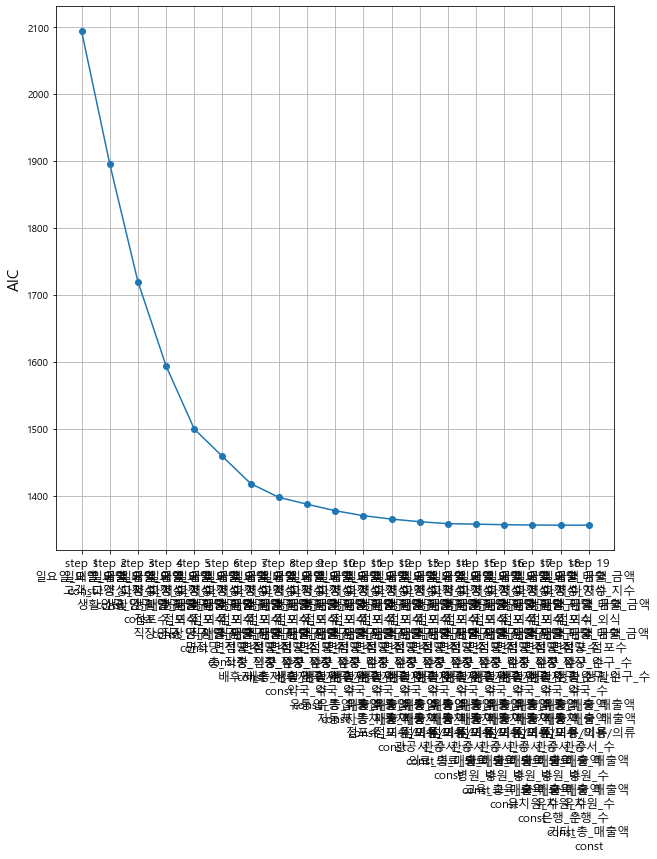

In [86]:
vis_AIC_step(s_AIC_model)

### R_square 모델

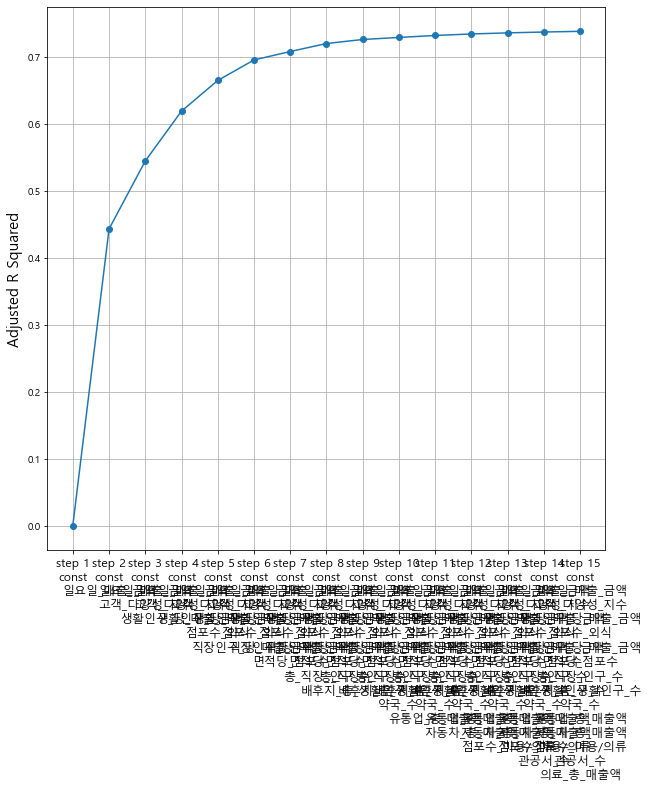

In [87]:
s_R_model = stepwise_R_sq(df_X, df_y)

In [88]:
df_y

0      23.4397
1      23.4955
2      24.0817
3      23.0956
4      23.0684
         ...  
1005   23.2491
1006   23.5703
1007   23.8443
1008   22.8874
1009   23.2350
Name: 1년_매출, Length: 989, dtype: float64

In [89]:
df_X.describe()

,const,배후지_총_생활인구_수,점포수_외식,점포수_미용/의류,폐업_점포_수,개업_점포_수,면적,면적당_점포수,면적당_미용의류_점포수,유흥_총_매출액,패션/미용_총_매출액,교육_총_매출액,요식_총_매출액,의료_총_매출액,자동차_총_매출액,기타_총_매출액,유통업_총_매출액,일요일_매출_금액,상권별_소득금액,고객_다양성_지수,생활인구_당_매출_금액,직장인구_당_매출_금액,총_직장_인구_수,공시지가,아파트_단지_수,아파트_가격_5억_이상_세대수,집객시설_수,관공서_수,은행_수,약국_수,유치원_수,대학교_수,숙박_시설_수,지하철_역_수,버스_정거장_수,초/중/고등학교_수,병원_수,지리_다양성_지수
count,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000,989.0000
mean,1.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000
std,0.0000,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005,1.0005
min,1.0000,-2.2619,-1.4101,-1.4994,-1.5304,-1.4779,-2.1158,-1.7029,-1.3120,-0.0824,-0.2840,-0.3755,-0.8210,-0.2943,-0.4552,-0.4151,-0.7404,-0.9640,-1.4109,-6.1172,-0.7589,-0.8814,-0.6802,-1.1575,-1.3416,-0.6463,-1.3666,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.9999,-0.2236,-0.2275,-2.8599
25%,1.0000,-0.6716,-0.6618,-0.6644,-0.7026,-0.6714,-0.6747,-0.6585,-0.6004,-0.0810,-0.2175,-0.3380,-0.5484,-0.2698,-0.4471,-0.3155,-0.4564,-0.5997,-0.7596,-0.4835,-0.5146,-0.5968,-0.5021,-0.5619,-0.7482,-0.6463,-0.7405,-0.6347,-0.4610,-0.9272,-0.3506,-0.1347,-0.2165,-0.1771,-0.5524,-0.2236,-0.2275,-0.5053
50%,1.0000,-0.0292,-0.2204,-0.1575,-0.1853,-0.2234,-0.0715,-0.1348,-0.2146,-0.0687,-0.1424,-0.2677,-0.2913,-0.2014,-0.3982,-0.1987,-0.2629,-0.2758,-0.2647,0.1299,-0.2703,-0.3093,-0.3464,-0.3089,-0.2589,-0.5137,-0.1144,-0.6347,-0.4610,-0.1687,-0.3506,-0.1347,-0.2165,-0.1771,-0.1050,-0.2236,-0.2275,0.1909
75%,1.0000,0.5618,0.3840,0.3942,0.4355,0.4039,0.4865,0.4674,0.2804,-0.0397,0.0016,-0.0466,0.1633,-0.0324,-0.1712,0.0415,0.1359,0.2469,0.4685,0.6840,0.1156,0.2118,0.0403,0.1082,0.4194,0.2546,0.5117,0.7449,-0.4610,0.5898,-0.3506,-0.1347,-0.2165,-0.1771,0.3425,-0.2236,-0.2275,0.6571
max,1.0000,7.2074,7.8960,7.9987,6.9541,8.8276,10.3463,10.2606,13.1739,30.6942,28.2730,18.8615,10.3794,21.0983,8.5908,26.2873,12.4773,11.5127,4.6590,2.0411,13.5282,8.8158,9.7792,7.0567,5.1106,6.7483,4.5811,6.2630,6.5262,4.3822,8.0392,19.2080,12.0183,9.0425,6.1595,10.6532,7.2709,1.9778


## 유효한 피쳐 선택

###  1차 회귀 결과

s_AIC_model
b_AIC_model
f_AIC_model

s_R_model
b_R_mdoel
f_R_model

In [90]:
s_best = get_best_summary_by_A(s_AIC_model)
s_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     157.7
Date:                Tue, 19 Oct 2021   Prob (F-statistic):          6.02e-273
Time:                        21:45:02   Log-Likelihood:                -658.99
No. Observations:                 989   AIC:                             1356.
Df Residuals:                     970   BIC:                             1449.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
일요일_매출_금액        0.1896      0.022      8.486      0.000       0.146       0.233
고객_다양성_지수        0.2236      0.017     13.131      0.000       0.190       0.257
생활인구_당_매출_금액     0.2250      0.023      9.826      0.000       0.180       0.270
점포수_외식           0.1297      0.020      6.362      0.000       0.090       0.170
직장인구_당_매출_금액     0.2023      0.020     10.309      0.000       0.164       0.241
면적당_점포수          0.1184      0.020      5.915      0.000       0.079       0.158
총_직장_인구_수        0.1222      0.019      6.551      0.000       0.086       0.159
배후지_총_생활인구_수     0.0728      0.018      4.052      0.000       0.038       0.108
약국_수             0.0481      0.019      2.594      0.010       0.012       0.084
유통업_총_매출액        0.0533      0.016      3.337      0.001       0.022       0.085
자동차_총_매출액        0.0440      0.016      2.829      0.005       0.013       0.075
점포수_미용/의류        0.0521      0.019      2.680      0.007       0.014       0.090
관공서_수            0.0392      0.015      2.547      0.011       0.009       0.069
의료_총_매출액         0.0318      0.016      2.033      0.042       0.001       0.062
병원_수             0.0241      0.016      1.534      0.125      -0.007       0.055
교육_총_매출액         0.0284      0.016      1.761      0.079      -0.003       0.060
유치원_수           -0.0253      0.015     -1.643      0.101      -0.055       0.005
은행_수            -0.0252      0.017     -1.494      0.135      -0.058       0.008
const           23.3980      0.015   1546.760      0.000      23.368      23.428
==============================================================================
Omnibus:                      422.886   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4407.059
Skew:                          -1.668   Prob(JB):                         0.00
Kurtosis:                      12.788   Cond. No.                         3.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
get_adj_r_squared_by_A_model(s_AIC_model)

0.741

In [92]:
r_best = get_best_summary_by_R(s_R_model)
r_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     200.8
Date:                Tue, 19 Oct 2021   Prob (F-statistic):          2.60e-275
Time:                        21:45:04   Log-Likelihood:                -664.15
No. Observations:                 989   AIC:                             1358.
Df Residuals:                     974   BIC:                             1432.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.3980      0.015   1541.890      0.000      23.368      23.428
일요일_매출_금액        0.1971      0.022      8.903      0.000       0.154       0.241
고객_다양성_지수        0.2209      0.017     12.994      0.000       0.188       0.254
생활인구_당_매출_금액     0.2249      0.023      9.921      0.000       0.180       0.269
점포수_외식           0.1270      0.020      6.226      0.000       0.087       0.167
직장인구_당_매출_금액     0.1957      0.020     10.017      0.000       0.157       0.234
면적당_점포수          0.1191      0.020      5.980      0.000       0.080       0.158
총_직장_인구_수        0.1198      0.018      6.486      0.000       0.084       0.156
배후지_총_생활인구_수     0.0738      0.018      4.105      0.000       0.039       0.109
약국_수             0.0507      0.018      2.807      0.005       0.015       0.086
유통업_총_매출액        0.0514      0.016      3.228      0.001       0.020       0.083
자동차_총_매출액        0.0456      0.016      2.924      0.004       0.015       0.076
점포수_미용/의류        0.0498      0.019      2.587      0.010       0.012       0.088
관공서_수            0.0386      0.015      2.500      0.013       0.008       0.069
의료_총_매출액         0.0347      0.016      2.215      0.027       0.004       0.065
==============================================================================
Omnibus:                      434.118   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4641.937
Skew:                          -1.717   Prob(JB):                         0.00
Kurtosis:                      13.043   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
get_adj_r_squared_by_R_model(s_R_model)

0.739

###  1차 feature 선택

In [94]:
AIC_feature_list=get_best_feature_by_A(s_AIC_model)

In [95]:
R_feature_list= get_best_feature_by_R(s_R_model)

In [96]:
최종_feature = list(set(AIC_feature_list + R_feature_list))

###### 최종 변수 vif check

In [97]:
vif_check_feature = get_vif(df_X.loc[:,최종_feature], 10)

    VIF Factor      features
0       2.2921  생활인구_당_매출_금액
1       1.4112  배후지_총_생활인구_수
2       1.1347      교육_총_매출액
3       1.0585     자동차_총_매출액
4       1.2440          은행_수
5       1.5218     총_직장_인구_수
6       1.2674     고객_다양성_지수
7       1.6488     점포수_미용/의류
8       1.5008          약국_수
9       1.8170        점포수_외식
10      1.7523       면적당_점포수
11      1.0766          병원_수
12      1.0679      의료_총_매출액
13      1.0000         const
14      1.1143     유통업_총_매출액
15      1.6826  직장인구_당_매출_금액
16      1.0344         유치원_수
17      2.1807     일요일_매출_금액
18      1.0369         관공서_수




In [98]:
vif_check_feature

,VIF Factor,features


In [99]:
vif_check_feature = vif_check_feature['features'].to_list()

vif 지수가 가장 높은 feature을 빼고 step 와이즈로 다시 모델링을 구성하여, R_square를 비교

import itertools

for i in itertools.combinations(vif_check_feature,3):
    print(i)

In [100]:
best_point1, best_point2 =get_adj_r_squared_by_A_model(s_AIC_model), get_adj_r_squared_by_R_model(s_R_model)

In [101]:
best_point1, best_point2

(0.741, 0.739)

In [102]:
df_X = df_X.loc[:, 최종_feature]

In [103]:
drop_list = get_clear_df_by_vif(df_X, 10)
df_X.drop(drop_list, axis=1, inplace=True)
get_vif(df_X, 10)

    VIF Factor      features
0       2.2921  생활인구_당_매출_금액
1       1.4112  배후지_총_생활인구_수
2       1.1347      교육_총_매출액
3       1.0585     자동차_총_매출액
4       1.2440          은행_수
5       1.5218     총_직장_인구_수
6       1.2674     고객_다양성_지수
7       1.6488     점포수_미용/의류
8       1.5008          약국_수
9       1.8170        점포수_외식
10      1.7523       면적당_점포수
11      1.0766          병원_수
12      1.0679      의료_총_매출액
13      1.0000         const
14      1.1143     유통업_총_매출액
15      1.6826  직장인구_당_매출_금액
16      1.0344         유치원_수
17      2.1807     일요일_매출_금액
18      1.0369         관공서_수




,VIF Factor,features


s_AIC_model = Stepwise_model(df_X, df_y)


s_R_model = stepwise_R_sq(df_X, df_y)


In [104]:
s_AIC_model = forward_model(df_X, df_y)

Processed  18 models on 1 predictors in 0.04404020309448242
Selected predictors: ['일요일_매출_금액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A4BF760>
Processed  17 models on 2 predictors in 0.04103732109069824
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A3A07F0>
Processed  16 models on 3 predictors in 0.039035797119140625
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7BC61D90>
Processed  15 models on 4 predictors in 0.038034677505493164
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', '생활인구_당_매출_금액', '점포수_외식', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001EB7A2D4E50>
Processed  14 models on 5 predictors in 0.035032033920288086
Selected predictors: ['일요일_매출_금액', '고객_다양성_지수', 

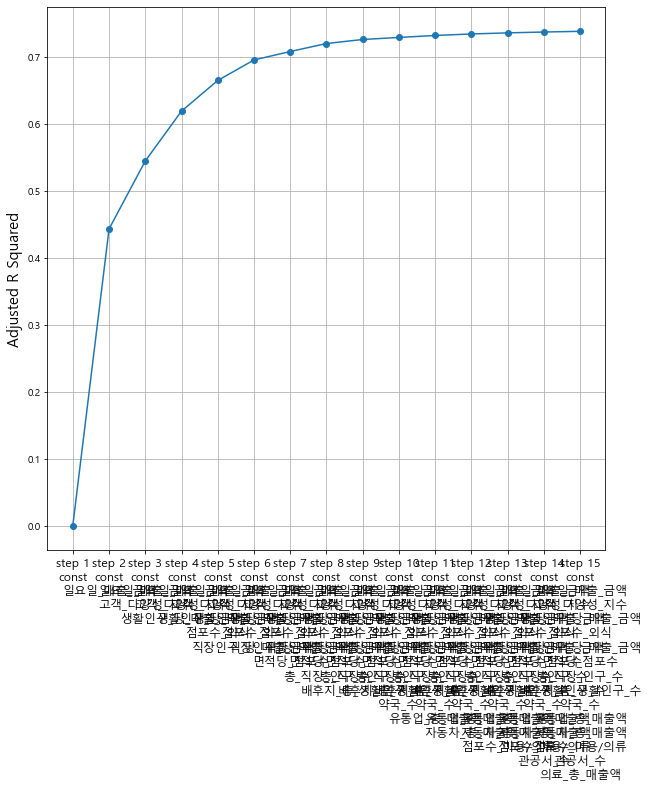

In [105]:
s_R_model = forward_R_sq(df_X, df_y)

In [106]:
s_best = get_best_summary_by_A(s_AIC_model)
s_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     157.7
Date:                Tue, 19 Oct 2021   Prob (F-statistic):          6.02e-273
Time:                        21:45:05   Log-Likelihood:                -658.99
No. Observations:                 989   AIC:                             1356.
Df Residuals:                     970   BIC:                             1449.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
일요일_매출_금액        0.1896      0.022      8.486      0.000       0.146       0.233
고객_다양성_지수        0.2236      0.017     13.131      0.000       0.190       0.257
생활인구_당_매출_금액     0.2250      0.023      9.826      0.000       0.180       0.270
점포수_외식           0.1297      0.020      6.362      0.000       0.090       0.170
직장인구_당_매출_금액     0.2023      0.020     10.309      0.000       0.164       0.241
면적당_점포수          0.1184      0.020      5.915      0.000       0.079       0.158
총_직장_인구_수        0.1222      0.019      6.551      0.000       0.086       0.159
배후지_총_생활인구_수     0.0728      0.018      4.052      0.000       0.038       0.108
약국_수             0.0481      0.019      2.594      0.010       0.012       0.084
유통업_총_매출액        0.0533      0.016      3.337      0.001       0.022       0.085
자동차_총_매출액        0.0440      0.016      2.829      0.005       0.013       0.075
점포수_미용/의류        0.0521      0.019      2.680      0.007       0.014       0.090
관공서_수            0.0392      0.015      2.547      0.011       0.009       0.069
의료_총_매출액         0.0318      0.016      2.033      0.042       0.001       0.062
병원_수             0.0241      0.016      1.534      0.125      -0.007       0.055
교육_총_매출액         0.0284      0.016      1.761      0.079      -0.003       0.060
유치원_수           -0.0253      0.015     -1.643      0.101      -0.055       0.005
은행_수            -0.0252      0.017     -1.494      0.135      -0.058       0.008
const           23.3980      0.015   1546.760      0.000      23.368      23.428
==============================================================================
Omnibus:                      422.886   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4407.059
Skew:                          -1.668   Prob(JB):                         0.00
Kurtosis:                      12.788   Cond. No.                         3.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
r_best = get_best_summary_by_R(s_R_model)
r_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  1년_매출   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     200.0
Date:                Tue, 19 Oct 2021   Prob (F-statistic):          1.16e-274
Time:                        21:45:06   Log-Likelihood:                -665.67
No. Observations:                 989   AIC:                             1361.
Df Residuals:                     974   BIC:                             1435.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.3980      0.015   1539.516      0.000      23.368      23.428
일요일_매출_금액        0.1976      0.022      8.914      0.000       0.154       0.241
고객_다양성_지수        0.2204      0.017     12.943      0.000       0.187       0.254
생활인구_당_매출_금액     0.2284      0.023     10.025      0.000       0.184       0.273
점포수_외식           0.1319      0.020      6.483      0.000       0.092       0.172
직장인구_당_매출_금액     0.1972      0.020     10.077      0.000       0.159       0.236
면적당_점포수          0.1184      0.020      5.934      0.000       0.079       0.158
총_직장_인구_수        0.1271      0.019      6.807      0.000       0.090       0.164
배후지_총_생활인구_수     0.0736      0.018      4.085      0.000       0.038       0.109
약국_수             0.0591      0.018      3.249      0.001       0.023       0.095
유통업_총_매출액        0.0552      0.016      3.457      0.001       0.024       0.087
자동차_총_매출액        0.0469      0.016      3.005      0.003       0.016       0.078
점포수_미용/의류        0.0516      0.019      2.672      0.008       0.014       0.089
관공서_수            0.0378      0.015      2.446      0.015       0.007       0.068
은행_수            -0.0233      0.017     -1.376      0.169      -0.056       0.010
==============================================================================
Omnibus:                      425.221   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4420.668
Skew:                          -1.681   Prob(JB):                         0.00
Kurtosis:                      12.797   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
# 최종 vif 체크 전
best_point1, best_point2

(0.741, 0.739)

In [109]:
get_adj_r_squared_by_A_model(s_AIC_model), get_adj_r_squared_by_R_model(s_R_model)

(0.741, 0.738)

In [110]:
AIC_feature_list=get_best_feature_by_A(s_AIC_model)

In [111]:
R_feature_list= get_best_feature_by_R(s_R_model)

In [112]:
최최종_feature = list(set(AIC_feature_list + R_feature_list))

In [113]:
최최종_feature

['생활인구_당_매출_금액',
 '배후지_총_생활인구_수',
 '교육_총_매출액',
 '자동차_총_매출액',
 '은행_수',
 '총_직장_인구_수',
 '고객_다양성_지수',
 '점포수_미용/의류',
 '약국_수',
 '점포수_외식',
 '면적당_점포수',
 '병원_수',
 '의료_총_매출액',
 'const',
 '유통업_총_매출액',
 '직장인구_당_매출_금액',
 '유치원_수',
 '일요일_매출_금액',
 '관공서_수']

# 저장 및 운송

In [114]:
ddd

NameError: name 'ddd' is not defined

In [ ]:
import pickle
 
## Save pickle
with open("data/indicator/매출기반_정규화_feature.pickle","wb") as fw:
    pickle.dump(최최종_feature, fw)
 

In [ ]:
get_best_summary_by_A(s_AIC_model)

In [ ]:
df_s_AIC_model = pd.read_html(get_best_summary_by_A(s_AIC_model).tables[1].as_html(),header=0,index_col=0)[0]

In [ ]:
get_adj_r_squared_by_A_model(s_AIC_model) # adj.r = 0.581

In [ ]:
with open("data/indicator/매출기반_정규화_AIC_coef.pickle","wb") as fw:
    pickle.dump(df_s_AIC_model, fw)
 

In [ ]:
df_s_R_model = pd.read_html(get_best_summary_by_R(s_R_model).tables[1].as_html(),header=0,index_col=0)[0]

In [ ]:
get_adj_r_squared_by_R_model(s_R_model)

In [ ]:
with open("data/indicator/매출기반_정규화_R_coef.pickle","wb") as fw:
    pickle.dump(df_s_R_model, fw)

----------------------------------------------------